Здесь представлено два различных агента, пытающихся удержаться 200 тиков в окружении CartPole.

Первый агент играет случайным образом, потом, как у него накопится достаточное количество успешных игр, запускается тренировка нейронной сети, которая пытается выучить действия, которые были совершены в этих самых удачных играх. Потом процесс запускается заново и так далее. Скорость работы такого варинта, правда, невысока.

Второй вариант использует нак называемые Q-values. Для этого инициализируется таблица значений, которые сопоставляются каждой паре положение-дейсствие. По мере работы агента эти значения обновляются, основываясь на действиях агента и получаемой награде по следующей формуле.


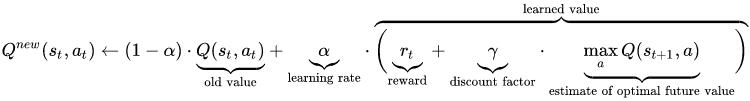

После этого для каждой новой позиции выбирается действие, в котором Q-value максимально.

    s_t -- положение системы
    a_t -- выбранное действие в s_t
    \alpha -- скорость обучения, то есть то, насколько сильно обновляется каждый раз значение 
    r_t -- награда за действие a_t
    \gamma -- то, насколько ценится будующая аграда по сравнению с наградой нынешней
    \epsilon -- "Exploration rate". То, с какой вероятностью агент совершает случайное действие, чтобы иметь возможность выйти из локального экстремума.

In [167]:
import random
import gym
import math
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [169]:
class CartPole():
    def __init__(self, name = 'CartPole-v0', episodes = 300, monitor = False, epsilon = .1, goal_ticks = 500, passing_pretrain = 150, train_period = 5000):
        self.env = gym.make(name)
        if monitor: 
            self.env = gym.wrappers.Monitor(self.env, '../data/cartpole-1', force=True)
        self.epsilon = epsilon
        self.episodes = episodes
        self.monitor = monitor
        self.memory = []
        self.goal_ticks = goal_ticks
        self.passing_pretrain = passing_pretrain
        self.train_period = train_period
        self.model = None
        
        
    def model_create(self, input_size):
        
        self.model = Sequential()
        self.model.add(Dense(32, input_shape = input_size,  activation='relu'))
        self.model.add(Dense(64, activation = 'relu'))
        self.model.add(Dense(128, activation = 'relu'))
        self.model.add(Dense(256, activation = 'relu'))
        self.model.add(Dense(512, activation = 'relu'))
        self.model.add(Dense(2, activation = 'softmax'))
        self.model.compile(loss='mse', optimizer=Adam())
          
    def choose_action(self, state, initial = True):
        if self.model is None:
            return ((np.sign((state.sum())) + 1) // 2).astype('int')
        else:
            return np.argmax(self.model.predict(np.array(state)[np.newaxis, ...]))

    def preprocess_state(self, state):
        return np.reshape(np.array(state), [1, 4])
    
    def train(self):
        X_train = [i[0] for i in self.memory]
        y_train = [i[1] for i in self.memory]
        
        if self.model is None:
            self.model_create([len(X_train[0])])
        
        X_train = np.vstack(X_train)
        self.model.fit(X_train, np.array(y_train), epochs = 3, verbose=100)
        self.passing_pretrain = int(self.passing_pretrain + 10)
        self.memory.clear()
        print('new_epoch')
    
    
    def play(self):
        rewards = []
        for episode in range(self.episodes):
            state = self.preprocess_state(self.env.reset())     
            state = state[0]
            scores = []
            over = False
            ticks = 0
            game_memory = []
            game_reward = 0
            while not over:
                if self.monitor:
                    self.env.render()
                action = self.choose_action(state, )
                next_state, reward, over, _ = self.env.step(action)
                if action == 0:
                    action = [1, 0]
                elif action == 1:
                    action = [0, 1]
                game_memory.append([state, action])
                state = next_state
                ticks += 1
                game_reward += reward
                
            if game_reward >= self.passing_pretrain:
                self.memory.extend(game_memory)
            rewards.append(game_reward)
                
            if len(self.memory) >= self.train_period:
                print(np.mean(rewards))
                if np.mean(rewards) >= 180:
                    self.monitor = True
                rewards.clear()
                self.train()
            
            scores.append(ticks)            
            if np.mean(ticks) >= 500:
                print('Hooray')
                
            else: 
                pass
        self.env.close()
                


In [170]:
cp = CartPole(monitor=False)
cp.play()

136.86046511627907
Epoch 1/3
Epoch 2/3
Epoch 3/3
new_epoch
137.50359712230215
Epoch 1/3
Epoch 2/3
Epoch 3/3
new_epoch


In [207]:
from collections import deque


class QPoleSolver():
    def __init__(self, n_episodes=3000, monitor = False):
        self.n_episodes = n_episodes
        self.monitor = monitor
        self.gamma = 1
        self.buckets = (1, 1, 6, 12)
        self.goal = 196
        
        self.env = gym.make('CartPole-v0')
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))
        
    
    def discretize(self, obs):
        upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(5)]
        lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(5)]
        ratios = [(obs[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(obs))]
        new_obs = [int(round((self.buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
        new_obs = [min(self.buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
        return tuple(new_obs)
    
    def get_epsilon(self, e):
        return max(0.0, np.exp(-e / 400))

    def get_alpha(self, e):
        return max(0.0, np.exp(-e / 400))
    
    def choose_action(self, state, epsilon):
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.Q_table[state])
    
    def update_q(self, state_old, action, reward, new_state, alpha):
        self.Q_table[state_old][action] += alpha * (reward + self.gamma * np.max(self.Q_table[new_state])
                                                        - self.Q_table[state_old][action])

    def run(self):
        scores = deque(maxlen=100)
        for e in range(self.n_episodes):
            current_state = self.discretize(self.env.reset())
            alpha = self.get_alpha(e)
            epsilon = self.get_epsilon(e)
            done = False
            i = 0

            while not done:
                action = self.choose_action(current_state, epsilon)
                observation, reward, done, _ = self.env.step(action)
                new_state = self.discretize(observation)
                self.update_q(current_state, action, reward, new_state, alpha)
                current_state = new_state
                i += 1

            scores.append(i)
            mean_score = np.mean(scores)
            if mean_score >= self.goal and e >= 100:
                print('Solved after {} episodes'.format(e, e - 100))
                return e - 100
            if e % 100 == 0:
                
                print('{}  -- {} ticks.'.format(e, mean_score))

        print('failed'.format(e))
        return e

In [208]:
QPoleSolver().run()

0  -- 16.0 ticks.
100  -- 22.61 ticks.
200  -- 22.62 ticks.
300  -- 32.39 ticks.
400  -- 40.22 ticks.
500  -- 44.79 ticks.
600  -- 60.11 ticks.
700  -- 84.71 ticks.
800  -- 97.54 ticks.
900  -- 129.22 ticks.
1000  -- 143.74 ticks.
1100  -- 166.95 ticks.
1200  -- 170.06 ticks.
Solved after 1216 trials


1116